# Smart Route Optimizer Project

**What is this Project?**  
This notebook simulates a last-mile delivery network of autonomous vehicles, demonstrating:  
- Route optimization via Google OR-Tools (VRP)  
- Edge-aware inference with network-latency simulation and fallback splitting  
- Distributed execution across multiple workers (Dask)  
- ETA prediction acceleration via ONNX export + dynamic quantization  
- A simple ML pre-routing step via K-Means clustering  

**Objective**  
1. Solve delivery-routing problems quickly under realistic network variability  
2. Adapt automatically when “edge” links are slow by splitting workloads  
3. Scale compute across local or cloud workers  
4. Compare raw vs. quantized model inference latency  
5. Seed routing with ML clusters to speed up solves  

**Results**  
- Solve-time comparison: central vs. network-simulated vs. distributed vs. cluster-seeded VRP  
- Inference latencies: ONNX vs. quantized, single-threaded vs. multi-threaded  
- Visual route maps for each method, plus cluster scatter plots  


In [24]:
# Install prerequisites (uncomment to run once in Colab)
# !pip install ortools matplotlib numpy dask[distributed] torch onnxruntime onnx scikit-learn

import random
import time
import matplotlib.pyplot as plt
import numpy as np

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from dask.distributed import Client, LocalCluster
import torch
import torch.nn as nn
from onnxruntime import InferenceSession
from onnxruntime.quantization import quantize_dynamic, QuantType
from concurrent.futures import ThreadPoolExecutor
from sklearn.cluster import KMeans


In [25]:
def generate_locations(num_locations, grid_size=10):
    """
    Generate random (x, y) locations within a grid.
    """
    return [
        (random.randint(0, grid_size), random.randint(0, grid_size))
        for _ in range(num_locations)
    ]

def compute_euclidean_distance_matrix(locations):
    """
    Build a symmetric matrix of pairwise Euclidean distances (int).
    """
    size = len(locations)
    matrix = [[0]*size for _ in range(size)]
    for i in range(size):
        for j in range(size):
            if i != j:
                x1, y1 = locations[i]
                x2, y2 = locations[j]
                matrix[i][j] = int(((x1-x2)**2 + (y1-y2)**2)**0.5)
    return matrix


In [26]:
def cluster_locations(locations, n_clusters):
    """
    Partition locations into n_clusters via K-Means.
    Returns:
      - labels: array of cluster IDs for each point
      - centers: cluster centroids (x, y)
    """
    coords = np.array(locations)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(coords)
    return labels, kmeans.cluster_centers_


In [27]:
def solve_vrp(distance_matrix, num_vehicles, depot=0):
    """
    Solve the Vehicle Routing Problem with OR-Tools.
    Returns a list of routes (each route is a list of node indices).
    """
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_vehicles, depot)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        return distance_matrix[
            manager.IndexToNode(from_index)
        ][manager.IndexToNode(to_index)]

    cb_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(cb_index)

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    solution = routing.SolveWithParameters(params)
    routes = []
    if solution:
        for vid in range(num_vehicles):
            idx = routing.Start(vid)
            route = []
            while not routing.IsEnd(idx):
                route.append(manager.IndexToNode(idx))
                idx = solution.Value(routing.NextVar(idx))
            route.append(manager.IndexToNode(idx))
            routes.append(route)
    return routes


In [28]:
def simulate_network_latency():
    """
    Sleep 50–200 ms to mimic network call delay; return the latency.
    """
    latency = random.uniform(0.05, 0.2)
    time.sleep(latency)
    return latency

def solve_vrp_with_network(distance_matrix, num_vehicles, depot=0, latency_threshold=0.1):
    """
    Attempt a central solve; if simulated latency > threshold,
    split the problem in half and solve each subproblem.
    """
    latency = simulate_network_latency()
    if latency > latency_threshold:
        print(f"High latency {latency:.3f}s – splitting subproblems")
        mid = len(distance_matrix)//2
        dm1 = [row[:mid] for row in distance_matrix[:mid]]
        dm2 = [row[mid:] for row in distance_matrix[mid:]]
        v1 = max(1, num_vehicles//2)
        v2 = num_vehicles - v1
        r1 = solve_vrp(dm1, v1, depot)
        r2 = solve_vrp(dm2, v2, depot)
        shifted = [[n+mid for n in route] for route in (r2 or [])]
        return (r1 or []) + shifted
    else:
        print(f"Latency {latency:.3f}s – central solve")
        return solve_vrp(distance_matrix, num_vehicles, depot)


In [29]:
def solve_vrp_distributed(distance_matrix, num_vehicles, depot=0, n_workers=2):
    """
    Distribute VRP subproblems across a local Dask cluster.
    """
    cluster = LocalCluster(n_workers=n_workers, threads_per_worker=1)
    client = Client(cluster)

    size = len(distance_matrix)
    mid = size // n_workers
    futures = []
    for i in range(n_workers):
        start, end = i*mid, (i+1)*mid if i < n_workers-1 else size
        sub_dm = [row[start:end] for row in distance_matrix[start:end]]
        v = max(1, num_vehicles//n_workers)
        futures.append(client.submit(solve_vrp, sub_dm, v, depot))

    results = client.gather(futures)
    routes = []
    for i, sub_routes in enumerate(results):
        offset = i*mid
        for route in sub_routes:
            routes.append([n+offset for n in route])
    client.close()
    return routes


In [30]:
def train_eta_model(num_samples=1000, input_dim=4, hidden_dim=16, epochs=20):
    """
    Train a toy MLP to predict Euclidean distance (ETA) between two points.
    Exports 'eta_model.onnx'.
    """
    X = np.random.rand(num_samples, input_dim)*10
    y = np.linalg.norm(X[:,:2] - X[:,2:], axis=1, keepdims=True)
    X_t, y_t = torch.from_numpy(X).float(), torch.from_numpy(y).float()

    model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    )
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        loss_fn(model(X_t), y_t).backward()
        opt.step()

    # Export to ONNX
    model.eval()
    torch.onnx.export(
        model, torch.randn(1, input_dim), "eta_model.onnx",
        input_names=["input"], output_names=["output"], opset_version=11
    )
    return "eta_model.onnx"

def quantize_model(input_onnx="eta_model.onnx", output_onnx="eta_model_q.onnx"):
    """
    Apply dynamic INT8 quantization to an ONNX model.
    """
    quantize_dynamic(input_onnx, output_onnx, weight_type=QuantType.QInt8)
    return output_onnx


In [31]:
def measure_onnx_inference(model_path, test_inputs, num_threads=4):
    """
    Measure single-threaded vs. multi-threaded ONNX Runtime inference.
    Returns (time_single, time_multi).
    """
    sess = InferenceSession(model_path, providers=["CPUExecutionProvider"])
    inp_name = sess.get_inputs()[0].name

    # single-threaded
    start = time.time()
    for inp in test_inputs:
        sess.run(None, {inp_name: inp.astype(np.float32)})
    t1 = time.time() - start

    # multi-threaded
    def run_one(x):
        sess.run(None, {inp_name: x.astype(np.float32)})

    start = time.time()
    with ThreadPoolExecutor(max_workers=num_threads) as ex:
        list(ex.map(run_one, test_inputs))
    t2 = time.time() - start

    return t1, t2


In [32]:
def plot_routes(locations, routes, title):
    """
    Visualize routes on a 2D scatter plot.
    """
    plt.figure(figsize=(6,6))
    for route in routes:
        xs = [locations[i][0] for i in route]
        ys = [locations[i][1] for i in route]
        plt.plot(xs, ys, '-o')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()


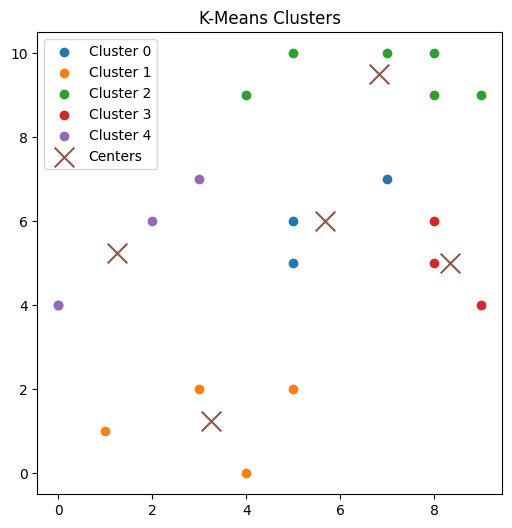

/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36287 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33477
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:36287/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45991'


High latency 0.156s – splitting subproblems


INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33299'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:40899 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40899
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60958
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:40813 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40813
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60964
INFO:distributed.scheduler:Receive client connection: Client-a19d851f-375a-11f0-9935-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60978
INFO:distributed.scheduler:Remove client Client-a19d851f-375a-11f0-9935-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:60978; closing.
INFO:distributed.scheduler:Remove client Client-a19d851f-375a-11f0-9935-0242ac1c000c
INFO:distributed.sche

Central: 0.019s | Network: 0.168s | Distributed: 2.644s | Clustered: 0.009s


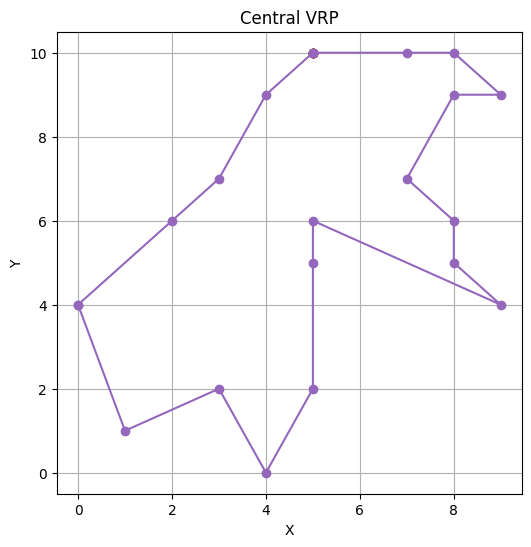

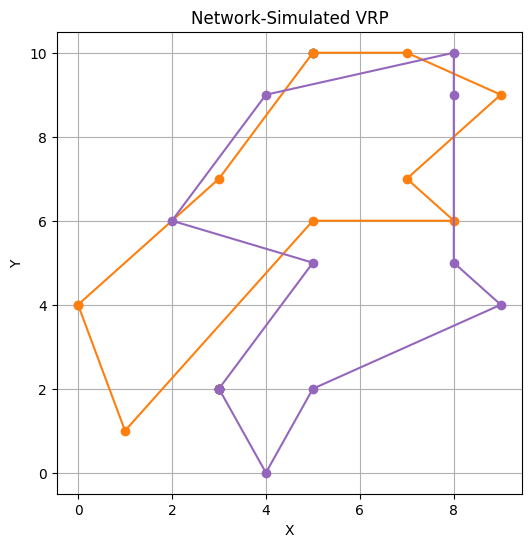

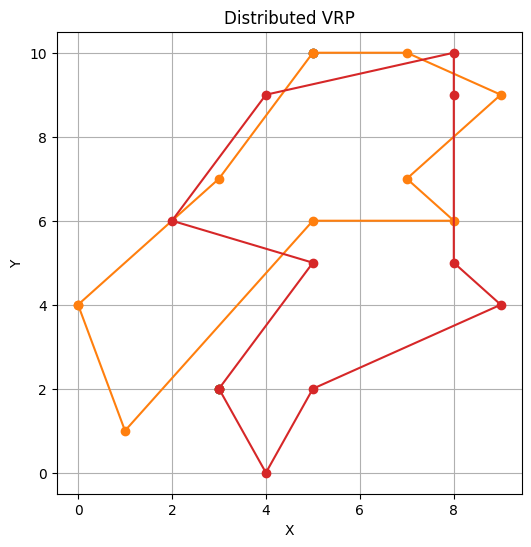

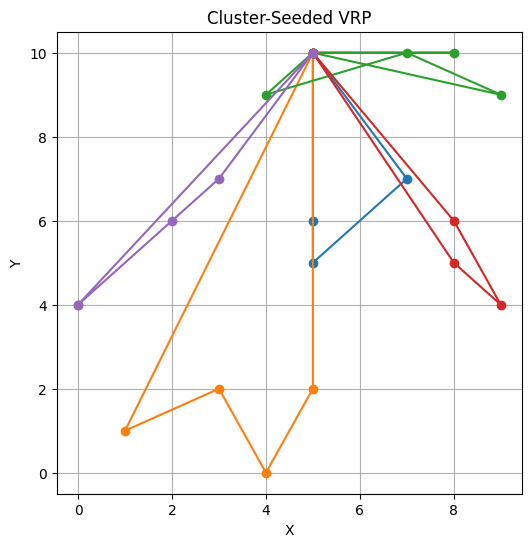

ONNX single: 0.003s | multi: 0.012s
Quant single: 0.003s | multi: 0.007s


In [33]:
# MAIN execution
NUM_LOCATIONS = 20
NUM_VEHICLES  = 5
GRID_SIZE     = 10
N_WORKERS     = 2

# 1) Generate data
locs = generate_locations(NUM_LOCATIONS, GRID_SIZE)
dm   = compute_euclidean_distance_matrix(locs)

# 2) Simple ML clustering pre-routing
labels, centers = cluster_locations(locs, NUM_VEHICLES)
plt.figure(figsize=(6,6))
for v in range(NUM_VEHICLES):
    pts = np.array(locs)[labels==v]
    plt.scatter(pts[:,0], pts[:,1], label=f"Cluster {v}")
plt.scatter(centers[:,0], centers[:,1], s=200, marker='x', label='Centers')
plt.title("K-Means Clusters")
plt.legend()
plt.show()

# 3) Time VRP methods
t0 = time.time()
central = solve_vrp(dm, NUM_VEHICLES)
t_c = time.time() - t0

t0 = time.time()
net     = solve_vrp_with_network(dm, NUM_VEHICLES)
t_n = time.time() - t0

t0 = time.time()
dist    = solve_vrp_distributed(dm, NUM_VEHICLES, n_workers=N_WORKERS)
t_d = time.time() - t0

# 4) Cluster-seeded VRP (one route per cluster)
clustered_routes = []
t0 = time.time()
for v in range(NUM_VEHICLES):
    idxs = [i for i, lbl in enumerate(labels) if lbl == v]
    sub_locs = [locs[0]] + [locs[i] for i in idxs if i != 0]
    sub_dm   = compute_euclidean_distance_matrix(sub_locs)
    sub_route = solve_vrp(sub_dm, 1, depot=0)
    if sub_route:
        mapped = [0 if node==0 else idxs[node-1] for node in sub_route[0]]
        clustered_routes.append(mapped)
    else:
        clustered_routes.append([])
t_cluster = time.time() - t0

print(f"Central: {t_c:.3f}s | Network: {t_n:.3f}s | Distributed: {t_d:.3f}s | Clustered: {t_cluster:.3f}s")

# 5) Plot all VRP solutions
plot_routes(locs, central,  'Central VRP')
plot_routes(locs, net,      'Network-Simulated VRP')
plot_routes(locs, dist,     'Distributed VRP')
plot_routes(locs, clustered_routes, 'Cluster-Seeded VRP')

# 6) Train & quantize ETA model
onnx_model = train_eta_model()
q_model    = quantize_model(onnx_model)

# 7) Measure ONNX inference
test_inputs = [np.random.rand(1,4)*10 for _ in range(100)]
t_o,  t_om  = measure_onnx_inference(onnx_model, test_inputs)
t_q,  t_qm  = measure_onnx_inference(q_model,    test_inputs)

print(f"ONNX single: {t_o:.3f}s | multi: {t_om:.3f}s")
print(f"Quant single: {t_q:.3f}s | multi: {t_qm:.3f}s")
